In [1]:
__author__ = "Matteo Pariset"

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.40

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.40


In [3]:
import pandas as pd

from experiment import *
from training import *
from viewer import Viewer

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

plt.rcParams["figure.figsize"] = (6.4, 4.8)

plt.rcParams['font.family'] = 'serif'
sns.set_context(context='talk', font_scale=.9)
palette = ['#1A254B', '#114083', '#A7BED3', '#F2545B', '#A4243B']

cmap = LinearSegmentedColormap.from_list('cmap', palette, N=18)

colors = ['#1A254B', '#114083', '#A7BED3', '#FFFFFF', '#F2545B', '#A4243B']
from matplotlib.colors import LinearSegmentedColormap
bcmap = LinearSegmentedColormap.from_list('bcmap', colors, N=100)

# Experiments on toy datasets

In [5]:
def plot_marginal(marginal, dim_reduction, **kwargs):
    plt.scatter(*dim_reduction(marginal).T, **kwargs)
    plt.axis("equal")
    
def plot_marginals(t0_marginal, t1_marginal, t0_color=cmap(.2), t1_color=cmap(.8), projection=lambda x: x, **kwargs):
    if 'alpha' not in kwargs:
        kwargs['alpha'] = .4
    plt.scatter(*projection(t0_marginal).T, color=t0_color, label=r"$t_0$", **kwargs)
    plt.scatter(*projection(t1_marginal).T, color=t1_color, label=r"$t_1$", **kwargs)
    plt.axis("equal")
    plt.legend();

def plot_multiple_marginals(marginals, statuses, dim_reduction, step_nums, normalize=False, labels=None):
    if normalize:
        marginals = norm_step(marginals)
    for i, s in enumerate(step_nums):
        if isinstance(labels, bool) and not labels:
            label = None
        elif labels is not None and len(labels) > 2:
            label = labels[i]
        elif labels is not None and len(labels) == 2:
            if s == step_nums[0]:
                label = labels[0]
            elif s == step_nums[-1]:
                label = labels[1]
            else:
                label = None
        else:
            label = None
        plot_marginal(marginals[i,statuses[i]], dim_reduction, s=.5, color=cmap(i/float(marginals.shape[0]-1)), label=label)
    plt.legend()

def plot_matchings(t0_points, t1_points, projection=lambda x: x, **kwargs):
    kwargs["color"] = kwargs.get("color", "gray")
    kwargs["alpha"] = kwargs.get("alpha", .7)
    kwargs["lw"] = kwargs.get("lw", .2)
    extended_coords = np.concatenate([projection(t0_points), projection(t1_points)], axis=1)
    plt.plot(extended_coords[:,::2].T, extended_coords[:,1::2].T, zorder=0, **kwargs);

def plot_predictions(preds, projection=lambda x: x):
    plt.scatter(*projection(preds[-1]).T, s=7.5, zorder=1, edgecolors="black", facecolors="black", label="predictions")

def draw_particle_paths(viewer, trajs=None):
    if trajs is None:
        trajs, _, statuses = viewer.get_fresh_trajectories(FORWARD)

    fig, ax = plt.subplots()

    selected_trajs = random.choice(viewer.key, trajs.shape[1], (5,))

    fig.set_size_inches(26, 15)
    plts = [
        ax.plot(*jnp.einsum("ijk->kij", trajs), color="grey", lw=.09)[0],
        ax.plot(*jnp.einsum("ijk->kij", trajs[:,selected_trajs]), color="black", lw=1)[0]
    ]

In [6]:
def export_fig(fig_name, force=True, extension="svg"):
    fig_path = f"../figures/{fig_name}.{extension}"
    if not os.path.exists(fig_path) or force:
        plt.savefig(fig_path, bbox_inches="tight", transparent=True)

In [7]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

def mmd_distance(x, y, gamma):
    xx = rbf_kernel(x, x, gamma)
    xy = rbf_kernel(x, y, gamma)
    yy = rbf_kernel(y, y, gamma)

    return xx.mean() + yy.mean() - 2 * xy.mean()

def compute_scalar_mmd(target, transport, gammas=None):
    if gammas is None:
        gammas = [2, 1, 0.5, 0.1, 0.01, 0.005]

    def safe_mmd(*args):
        try:
            mmd = mmd_distance(*args)
        except ValueError:
            mmd = np.nan
        return mmd

    return np.mean(list(map(lambda x: safe_mmd(target, transport, x), gammas)))


def square_norm(vec):
    return np.square(vec).sum(axis=-1)

def compute_rmsd(target, predicted):
    return np.sqrt(square_norm(target-predicted).mean(axis=0))

def compute_norm_rmsd(target, predicted):
    return compute_rmsd(target, predicted) / (np.sqrt(square_norm(target).max()) - np.sqrt(square_norm(target).min()))

# def compute_l2_difference(target, predicted):
#     return np.sqrt(square_norm(target-predicted)).mean(axis=0)

def compute_l2_difference(target, predicted):
    return np.sqrt(square_norm(target.mean(axis=0) - predicted.mean(axis=0)))

import jax
import jax.numpy as jnp
import ott
def make_geometry(t0_points, t1_points):
    """ Set up inital/final cloud points living in space endowed with squared Eucliden distance
    """
    point_cloud = ott.geometry.pointcloud.PointCloud(t0_points, t1_points, ott.geometry.costs.SqEuclidean())
    return point_cloud
def compute_ot(t0_points, t1_points):
    """ Solve OT problem
    """
    point_cloud = make_geometry(t0_points, t1_points)
    sinkhorn = ott.solvers.linear.sinkhorn.Sinkhorn()(ott.problems.linear.linear_problem.LinearProblem(point_cloud))
    return sinkhorn
def transport(ot, init_points):
    return ot.to_dual_potentials().transport(init_points)
def compute_wasserstein_2(preds, true):
    ot = compute_ot(preds, true)
    return jnp.sqrt(ot.transport_cost_at_geom(make_geometry(preds, true))).item()

def compute_metrics(target, predicted):
    return {
        'mmd': compute_scalar_mmd(target, predicted),
        'norm_rmsd': compute_norm_rmsd(target, predicted).item(),
        'l2': compute_l2_difference(target, predicted).item(),
        'w2': compute_wasserstein_2(target, predicted),
    }

In [8]:
def draw_trajs_with_killing(experiment):
    viewer = Viewer(random.PRNGKey(0), experiment)
    sampled_trajs = [viewer.get_fresh_trajectories(FORWARD) for _ in range(4)]
    trajs, statuses = jnp.concatenate([x[0] for x in sampled_trajs], axis=1), jnp.concatenate([x[2] for x in sampled_trajs], axis=1)

    plot_marginals(
        experiment.start_marginals_sampler[FORWARD](viewer.key)[:300],
        experiment.start_marginals_sampler[BACKWARD](viewer.key)[:300],
        projection=experiment.e.project)
    plot_multiple_marginals(trajs[::12], statuses[::12], experiment.e.project, range(0, 100, 12), labels=False)
    draw_patches(load_patches(experiment.e.killing_function_name), time=None, fig_handle=(plt.gcf(), plt.gca()));

    # Identify deaths
    death_frame = jnp.cumsum(1-statuses, axis=0) == 1
    death_frame = death_frame.at[0].set(False)
    for f_num, d_mask in enumerate(death_frame):
        plot_marginal(trajs.at[f_num, d_mask].get(), dim_reduction=experiment.e.project, s=1., color="black", zorder=10)

    # Identify births
    birth_frame = (jnp.cumsum(1-statuses[::-1], axis=0) == 1)[::-1]
    birth_frame = birth_frame.at[-1].set(False)
    for f_num, b_mask in enumerate(birth_frame):
        plot_marginal(trajs.at[f_num, b_mask].get(), dim_reduction=experiment.e.project, s=5., marker="P", color="white", edgecolors="black", linewidths=.3, zorder=10)


    runs = []
    for _ in range(3):
        sampled_trajs = [viewer.get_fresh_trajectories(FORWARD) for _ in range(4)]
        trajs, statuses = jnp.concatenate([x[0] for x in sampled_trajs], axis=1), jnp.concatenate([x[2] for x in sampled_trajs], axis=1)
        samples_num = min(400, statuses[-1].sum())
        runs.append(compute_metrics(viewer.get_fresh_marginal(BACKWARD)[:samples_num], trajs.at[-1, statuses[-1]].get()[:samples_num]))
    
    print(pd.DataFrame(runs).mean())

    plt.axis("off")

# UDSB-TD

## Horseshoe dataset

### Training

In [9]:
# def get_death_config():
#     dataset_config = {
#         'dataset_name': "toy",
#         'state_dims': 2,
#         'killing_function_name': 'centered_rectangle_dead_pool', # 'centered_rectangle_dead_pool'
#     }

#     experiment_config = {
#         ## Experiment-dependent variables ############################
#         'objective': "divergence",

#         'mass_0': 1000,
#         'mass_1': None,

#         'init_components_num': 2,
#         'end_components_num': 2,

#         'steps_num': 100,
#         'batch_size': 512,
#         'paths_reuse': 5,
#         'hidden_dims': 32,

#         'eps': 1e-7,
#         'neginf': -10,
#         'plusinf': 7,

#         'experiment_name': f"v3_comparison_v4",
#     }

#     config = {
#         "dataset": dataset_config,
#         "experiment": experiment_config
#     }

#     return config

In [ ]:
# def run_death_experiment():
#     # Define mass constraints
#     end_mass = jnp.linspace(450, 1000, 6)

#     # Load config
#     config = get_death_config()

#     # Store statistics
#     obtained_end = []

#     for em in end_mass:
#         print(f"1000 -> {em}")

#         config['experiment']['mass_1'] = int(em)

#         experiment = Experiment.create(config)
#         trainer = Trainer(random.PRNGKey(0), experiment)

#         trainer.train([0., .5, 1.])
#         experiment.save(f"v3_final_death_no-mask_warmup_mass-{int(em)}")

#         viewer = Viewer(random.PRNGKey(0), experiment)
#         _, _, sim_statuses = viewer.get_fresh_trajectories(FORWARD)
#         obtained_end.append(sim_statuses[100].mean())

#     print("desired em:", end_mass)
#     print("obtained em:", jnp.array(obtained_end))

# run_death_experiment()

In [35]:
# # def final_finetuning(i):
# #     tmp_viewer = Viewer(random.PRNGKey(0), d_experiments[i])

# #     tmp_viewer.key, tmp_key_f, tmp_key_b = random.split(tmp_viewer.key, 3)
# #     tmp_trainer = Trainer(random.PRNGKey(0), Experiment.load("toy", f"{d_experiment_prefix}-{d_end_masses[i]:.0f}"))
# #     tmp_viewer.key, tmp_key_f, tmp_key_b = random.split(tmp_viewer.key, 3)
# #     tmp_key = {FORWARD: tmp_key_f, BACKWARD: tmp_key_b}

# #     for _ in range(5):
# #         tmp_key, new_psi = tmp_trainer.finetune_psi(tmp_key, d_experiments[i].get_params(), d_experiments[i].get_psi())
# #         d_experiments[i].experiment_state = d_experiments[i].experiment_state[:2] + (new_psi, )

# #     _, _, tmp_statuses = tmp_viewer.get_fresh_trajectories(FORWARD)
# #     print(tmp_statuses[-1].mean())

# # for i in range(d_end_masses.shape[0]):
# #     final_finetuning(i)

# # for i, em in enumerate(d_end_masses):
# #     d_experiments[i].save(f"v3_final_death_no-mask_warmup_finetuned_mass-{em:.0f}")

### Inference

Load trained models and plot figures

In [36]:
d_experiment_prefix = "v3_final_death_no-mask_warmup_finetuned_mass"
d_end_masses = jnp.linspace(450, 1000, 6)
d_runs_num = d_end_masses.shape[0]

In [37]:
d_experiments, d_trajs, d_statuses = [], [], []
for em in d_end_masses:
    d_experiment = Experiment.load("toy", f"{d_experiment_prefix}-{em:.0f}")
    d_viewer = Viewer(random.PRNGKey(0), d_experiment)
    run_traj, _, run_status = d_viewer.get_fresh_trajectories(FORWARD)
    d_experiments.append(d_experiment)
    d_trajs.append(run_traj)
    d_statuses.append(run_status)

d_trajs = jnp.stack(d_trajs)
d_statuses = jnp.stack(d_statuses)

[INFO]: Reloading params from cache
[INFO]: Reloading params from cache
[INFO]: Reloading params from cache
[INFO]: Reloading params from cache
[INFO]: Reloading params from cache
[INFO]: Reloading params from cache


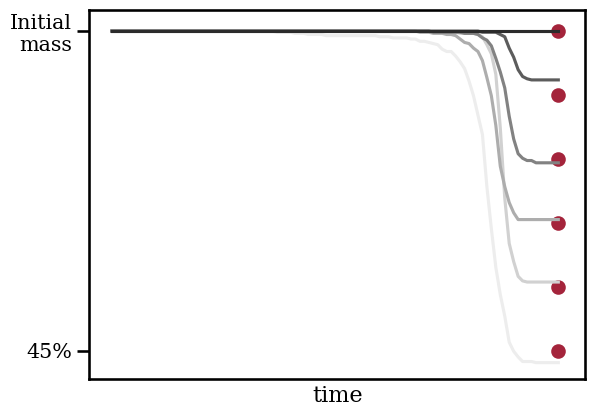

In [43]:
for run_idx, run_alive_num in enumerate(d_statuses.mean(axis=-1)):
    plt.plot(run_alive_num / run_alive_num[0] * 1000, c=plt.cm.Greys((run_idx+1)/(d_runs_num+1)));
    plt.scatter(100, d_end_masses[run_idx], c=cmap([1.]))

plt.yticks([450, 1000], labels=["45%", "Initial\nmass"])
plt.xticks([])
plt.xlabel("time")

export_fig("sb_baseline_toy_death_counts")

mmd          0.008927
norm_rmsd    4.777111
l2           0.281588
w2           1.327295
dtype: float64


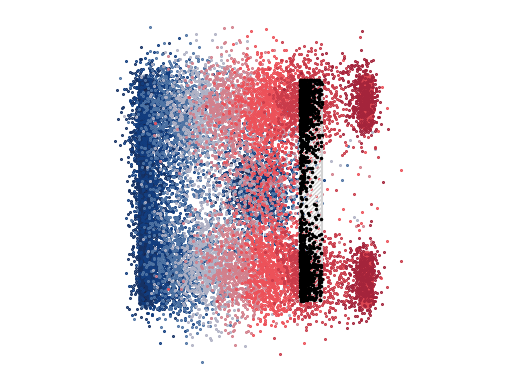

mmd          0.009492
norm_rmsd    4.718472
l2           0.396667
w2           1.606103
dtype: float64


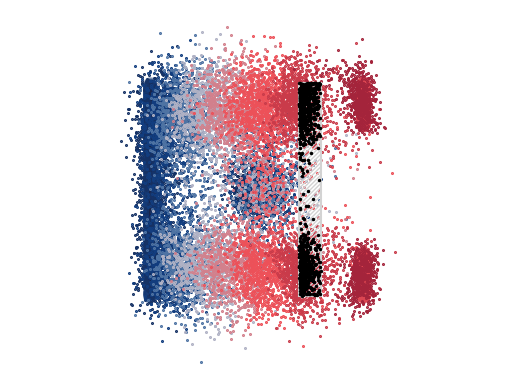

mmd          0.003278
norm_rmsd    4.700765
l2           0.175994
w2           1.143192
dtype: float64


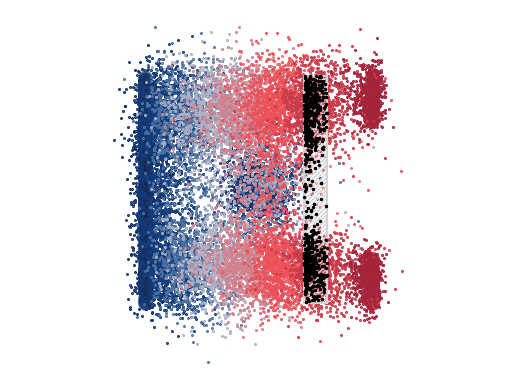

mmd          0.005777
norm_rmsd    4.745880
l2           0.401742
w2           1.520019
dtype: float64


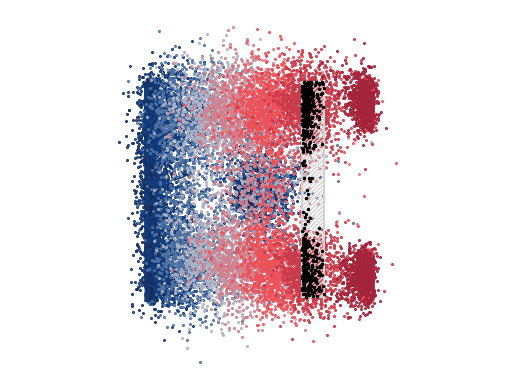

mmd          0.005432
norm_rmsd    4.582506
l2           0.131885
w2           0.961625
dtype: float64


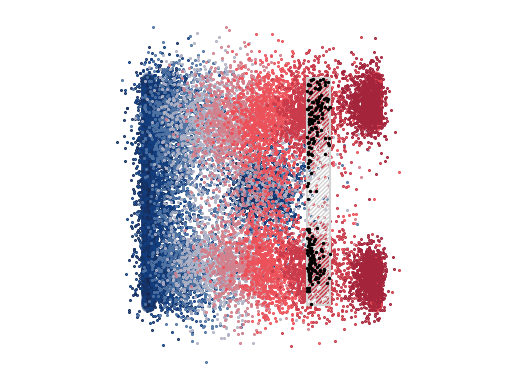

mmd          0.017373
norm_rmsd    4.744508
l2           0.321355
w2           1.238335
dtype: float64


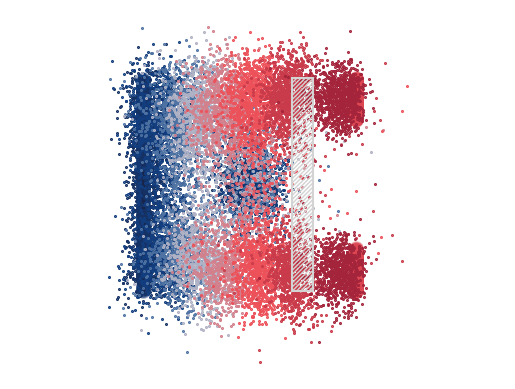

In [39]:
for exp in d_experiments:
    draw_trajs_with_killing(exp)
    plt.gca().legend().remove()
    export_fig(f"usb_theory_baseline_death_{exp.e.mass_1}_trajs")
    plt.show()